# OIL & GAS PRODUCTION - Text Mining Accident Reports 

### This project analyzes worker accidents based on the summary reports provided by Occupational Safety and Health Administration (OSHA) and classified according to NAICS system. 



## Outline:
The following are the steps required in performing the necessary analysis on the textual corpus of accident reports. 
Each of these steps further contain multiple tasks which are discussed in detail under their respective sections.
### 1. Data Acquisition
### 2. Text Preprocessing 
### 3. Text Structuring
### 4. Text Mining 
### 5. Advanced Analytics
### 6. Interactive Interface
___

## 1. Data Acquisition 
The datasets are obtained from "osha.gov" website. Each accident report contains the **Summary** along with **Report ID**, **Event Date** and **Degree**.
The last column **Degree** explains whether the accident resulted in a fatality or hospitalization of the victim. This feature can become useful (as a dependent variable) for text classification. 


### Importing Data into Python Environment
There are two data files for different naics codes, we will import them both into a pandas dataframe and later combine their rows to be sorted by date. 

In [1]:
import pandas as pd

#read in the data files
ncs_21311_df = pd.read_csv('data/naics_21311_data.csv', sep = ',', header=0, parse_dates = ['Event_Date'], na_values="")
ncs_237120_df = pd.read_csv('data/naics_237120_data.csv', sep = ',', header=0, parse_dates = ['Event_Date'], na_values="")

dfs = [ncs_21311_df,ncs_237120_df]
raw_data =  pd.concat(dfs,  ignore_index=True)   #combine the two dataframes
raw_data.sort_values(by='Event_Date', inplace = True) #sort by event date
raw_data.reset_index(drop = True, inplace = True) #reset index from 0

Lets have a look into the data and its columns to observe any content of interest. 

In [2]:
raw_data.tail()

Report_ID Event_Date   Age      Nature  \
1146     626300 2017-11-28  30.0  Concussion   
1147     950647 2017-12-04  21.0    Fracture   
1148     627700 2017-12-21  35.0    Fracture   
1149     627700 2017-12-30  28.0    Fracture   
1150     627700 2017-12-31  50.0       Other   

                              Establishment  \
1146  Southern Petroleum Laboratories, Inc.   
1147        Applied Technologies Associates   
1148                 Ricks Well Service Llc   
1149                H.L. Morris Farms, Inc.   
1150                Ada Energy Service, Llc   

                                                Summary               Degree  
1146  At 12:18 p.m. on November 28, 2017, Employee #...  Hospitalized injury  
1147  At 11:40 a.m. on December 4, 2017, an employee...  Hospitalized injury  
1148  At 10:45 a.m. on December 21, 2017, an employe...             Fatality  
1149  At 11:00 a.m. on December 30, 2017, an employe...             Fatality  
1150  At 9:30 a.m. on December 31, 2017, an employee...             Fatality

**Missing Values**

In [3]:
raw_data.isnull().sum()

Report_ID          0
Event_Date         0
Age              744
Nature            10
Establishment      0
Summary            0
Degree            10
dtype: int64

About 70% of Age information is missing, and 10 rows in Degree column are missing. We need to drop the Age row later for analysis and delete missing rows in Degree column.

In [4]:
raw_data = raw_data[pd.notnull(raw_data['Degree'])]

**Creating Time field:** The dataset has 1151 rows and 7 columns. Each summary report begins with a phrase that contains the **time** when the accident happened. Not all reports contain time, but most of them have it. It can be of some use while performing time based analytics/prediction in future. Keeping the **time field** in a separate column will be convenient for testing correlation rather than including it in the report summary. So, we will split our report text to create a new time column in the dataframe.

In [5]:
df = raw_data #add data to a temporary dataframe
""" All rows contain date-year, so split based on year in string.
For str.split() method specify the pattern as 1st argument,
We only need one split to happen - which is the 2nd argument,
expand=True returns a dataframe with 2 columns"""
tmp = df.Summary.str.split("20\d+", n=1, expand=True) 

raw_data['Time'] = tmp[0]
raw_data = raw_data[['Report_ID', 'Event_Date', 'Age', 'Time', 'Nature', 'Establishment', 'Summary', 'Degree']]
raw_data.tail()

Report_ID Event_Date   Age                            Time      Nature  \
1146     626300 2017-11-28  30.0  At 12:18 p.m. on November 28,   Concussion   
1147     950647 2017-12-04  21.0   At 11:40 a.m. on December 4,     Fracture   
1148     627700 2017-12-21  35.0  At 10:45 a.m. on December 21,     Fracture   
1149     627700 2017-12-30  28.0  At 11:00 a.m. on December 30,     Fracture   
1150     627700 2017-12-31  50.0   At 9:30 a.m. on December 31,        Other   

                              Establishment  \
1146  Southern Petroleum Laboratories, Inc.   
1147        Applied Technologies Associates   
1148                 Ricks Well Service Llc   
1149                H.L. Morris Farms, Inc.   
1150                Ada Energy Service, Llc   

                                                Summary               Degree  
1146  At 12:18 p.m. on November 28, 2017, Employee #...  Hospitalized injury  
1147  At 11:40 a.m. on December 4, 2017, an employee...  Hospitalized injury  
1148  At 10:45 a.m. on December 21, 2017, an employe...             Fatality  
1149  At 11:00 a.m. on December 30, 2017, an employe...             Fatality  
1150  At 9:30 a.m. on December 31, 2017, an employee...             Fatality

**Clean Time Field** : 
The time column consists of text string which needs to be transformed to contain only the time information in an appropriate format. So, the strings needs to be sliced and converted to a datetime format. Then the time accuracy should be reduced to hour of day. 

In [6]:
# Time content is to be extracted from string and modify into a suitable format for coversion into time field
raw_data.Time = raw_data.Time.str.extract('(\d+:\d+ \w.\w.)') #select time based on regex 
raw_data.Time = raw_data.Time.str.upper() #convert to uppercase
raw_data.Time = raw_data.Time.str.replace(".", "", n=-1)  #remove periods
raw_data.Time = pd.to_datetime(raw_data.Time, errors='coerce', format='%I:%M %p')  #convert to time

In [7]:
from datetime import datetime, timedelta
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

raw_data.Time = raw_data.Time.apply(lambda i: hour_rounder(i) if str(i)!="NaT" else i)
raw_data.Time = raw_data.Time.dt.hour
raw_data.Time = raw_data.Time.astype('category')

The missing values of Summary column are now filled and we shall now make a copy of the **Summary** column to perform text preprocessing

In [8]:
reports = raw_data['Summary']
reports.head()

0    Employee #1 and other employees were tripping ...
1    Employee #1 was working on an oil rig while th...
2    Three employees of a well service company were...
3    Employee #1 had climbed to the monkeyboard of ...
4    On December 20, 2001, Employee #1 was in the p...
Name: Summary, dtype: object

In [9]:
# export as csv files
raw_data.to_csv('raw_data.csv', sep=',', encoding='utf-8', index = False)

## 2. Text Preprocessing
Preprocessing is an important yet time-consuming process in analyzing textual data. It is vital because we need to convert human readable text into machine readable format which involves several steps with multiple tools or packages. Rather than importing all packages at the beginning, for now I will import each of them where they are used in their respective cells.  

### Text Normalization
We will start with Text Normalization which includes:
- **converting all letters to lower or upper case**
- **converting numbers into words or removing numbers**
- **removing punctuations, accent marks and other diacritics**
- **removing white spaces**
- **expanding abbreviations**
- **removing stop words, sparse terms, and particular words**

Depending on our needs and nature of the data some of these steps might be redundant. We can remove or add some steps as we seem fit to not lose any important details in the data.  


#### Convert text to lowercase

In [10]:
reports = reports.str.lower()
reports[3] #peek at a report

'employee #1 had climbed to the monkeyboard of a drilling rig. he was wearing a full fall protection harness. while he was climbing, he had been hooked up to a climbing-assist apparatus manufactured by dbi. the monkeyboard was located approximately 85 feet from the floor. he was up there for 7 to 10 minutes, waiting for coworkers to send up the blocks. the blocks were sent up, and employee #1 leaned out to put the pipe in the block. his coworkers noticed that he had not tied himself off to the fall protection cable or to the tail rope, which the employees had used for positioning. as employee #1 tried to grab the pipe, he fell to his death still wearing his harness.'

#### Remove numbers
Generally numbers are not relevant for text analysis as it can be more difficult to extract context or meaning from numbers than from words. In our report, we can observe that the numbers used indicate time and date which is already provided in a separate field if we need them. The last line in the report contains vital information that "three employees are killed" in word form, thus we are not discarding any useful data. 

In [11]:
reports = reports.str.replace("\d+", "", n=-1)   
reports[3] #peek at a report

'employee # had climbed to the monkeyboard of a drilling rig. he was wearing a full fall protection harness. while he was climbing, he had been hooked up to a climbing-assist apparatus manufactured by dbi. the monkeyboard was located approximately  feet from the floor. he was up there for  to  minutes, waiting for coworkers to send up the blocks. the blocks were sent up, and employee # leaned out to put the pipe in the block. his coworkers noticed that he had not tied himself off to the fall protection cable or to the tail rope, which the employees had used for positioning. as employee # tried to grab the pipe, he fell to his death still wearing his harness.'

#### Remove Punctuation
We can use the `re` regex and `string` library to select and remove any symbols like [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]: 

In [12]:
import re
import string  # Along with importing string, we are also using the 're' Regex library
reports = reports.str.replace('[%s]' % re.escape(string.punctuation), '', n=-1)
reports[3] #peek at a report

'employee  had climbed to the monkeyboard of a drilling rig he was wearing a full fall protection harness while he was climbing he had been hooked up to a climbingassist apparatus manufactured by dbi the monkeyboard was located approximately  feet from the floor he was up there for  to  minutes waiting for coworkers to send up the blocks the blocks were sent up and employee  leaned out to put the pipe in the block his coworkers noticed that he had not tied himself off to the fall protection cable or to the tail rope which the employees had used for positioning as employee  tried to grab the pipe he fell to his death still wearing his harness'

#### Remove whitespaces
We will use the pandas `str.strip()` method to remove ant leading or trailing whitespaces and `re.sub` method from Regex to remove any duplicate whitespaces between words.

In [13]:
reports = reports.str.strip()
reports = reports.str.replace(' +', ' ',n=-1)
reports[3]

'employee had climbed to the monkeyboard of a drilling rig he was wearing a full fall protection harness while he was climbing he had been hooked up to a climbingassist apparatus manufactured by dbi the monkeyboard was located approximately feet from the floor he was up there for to minutes waiting for coworkers to send up the blocks the blocks were sent up and employee leaned out to put the pipe in the block his coworkers noticed that he had not tied himself off to the fall protection cable or to the tail rope which the employees had used for positioning as employee tried to grab the pipe he fell to his death still wearing his harness'

#### Tokenize to remove stopwords
Tokenization is the process of splitting the given text into smaller pieces called tokens. Stop words (or commonly occurring words) should be removed from the text data as they do not provide any value and also makes our word matrix much sparse later. For this purpose, we can either create a list of stopwords ourselves or we can use predefined libraries. Here we'll use `nltk` library which contains all basic stopwords in English language. 
Apart from these words we can also remove some specific words by creating a word set.


In [14]:
import nltk  
"""
If python gives out error for not finding some subpackages, 
running these code lines may help: 
nltk.download('stopwords')
nltk.download('punkt') 
"""
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# tokenize
word_tokens = reports.apply(lambda r: word_tokenize(r))
word_tokens.head()

0    [employee, and, other, employees, were, trippi...
1    [employee, was, working, on, an, oil, rig, whi...
2    [three, employees, of, a, well, service, compa...
3    [employee, had, climbed, to, the, monkeyboard,...
4    [on, december, employee, was, in, the, process...
Name: Summary, dtype: object

#### Removing Stopwords and Common words: 
Apart from the common language stopwords explained above there are other kinds of words not useful for the analysis. For example these words can be names of months or any common words highly used but not excluded by the stopwords library. We will first remove known stopwords and common words and then check the data for most frequently occuring words.

In [15]:
# For now we will remove basic stopwords and month names from the tokens
rmv_words = {'january', 'february', 'march', 'april','may','june','july','august','september','october','november','december', 'am', 'pm', 'however', 'first', 'one', 'two', 'three', 'five'}
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union(rmv_words)
word_tokens = word_tokens.apply(lambda t: [i for i in t if not i in stop_words]) 
word_tokens.head()

0    [employee, employees, tripping, pipe, rotary, ...
1    [employee, working, oil, rig, rig, dismantled,...
2    [employees, well, service, company, rigging, w...
3    [employee, climbed, monkeyboard, drilling, rig...
4    [employee, process, closing, well, prior, blee...
Name: Summary, dtype: object

Now check the data for ten most frequent words and justify whether we need to remove or retain them.

In [16]:
freq = word_tokens.values.flatten().tolist()
freq = pd.Series(item for sublist in freq for item in sublist)
print(freq.value_counts()[:10])
print(len(freq.value_counts()))

employee         3693
pipe              702
approximately     651
well              626
rig               588
truck             469
employees         438
struck            385
oil               376
killed            368
dtype: int64
5674


The above words are all related to the accidents and we cannot immediately discard any of them. We need to observe how they are related to form relationships and if some of them are not adding value we can then remove them.

#### Removing rare words
As we have seen common words, it is more important to check rare words as well. Because each word is a column in the sparse matrix and if a word is rare it mostly contains null values, thus adding complexity while developing a model for prediction or classification. Ignoring terms that have a document frequency lower than a given threshold can help generalization and prevent overfitting, we need to limit ourselves to the set of values that aid to show strong associations. So, to remove the sparse terms we need to set up a threshold, and to calculate an ideal threshold we need to look into the distribution of the word frequencies. 

In [17]:
import matplotlib.pyplot as plt

dst = freq.value_counts()[1:] # exclude first value, it impairs detail in plot 
dst.plot.bar(figsize=(20,5), title="Frequency Distribution Plot")
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)  
plt.show()
plt.close()

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<Figure size 2000x500 with 1 Axes>

The distribution is extremely skewed to right and logarithmic in nature. There are total of 2672 terms/words and most of them have a frequency less than 25. Due to this nature of data (as most values are of low frequencies) the distribution is flipped and the high frequency terms will be outliers. We can view these with the boxplot which can help us with the threshold to eliminate rare words.

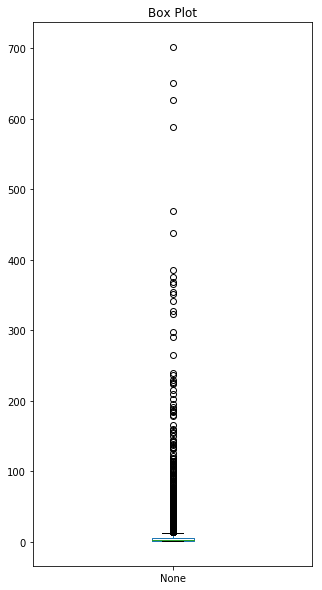

In [18]:
dst.plot.box(figsize=(5,10), title="Box Plot")
plt.show()
plt.close()

As expected all rare words occupied the distribution which has an upper limit around 10. So, we will remove all rare which have repeat less than 10 times in the entire corpus.

In [19]:
rare_words = freq.value_counts()[freq.value_counts() < 10]
rare_words = list(rare_words.index)
len(rare_words)

4656

The sparse matrix to be created is reduced close to 10% of its initial size. This makes it convenient to build a time and space efficient model that can generalize well. If necessary we can always trim down the model later based on its performance.

In [20]:
# Remove words from word tokens
word_tokens = word_tokens.apply(lambda t: [i for i in t if not i in rare_words]) 

### Part of speech (POS) Tagging
Part-of-speech tagging aims to assign parts of speech to each word of a given text (such as nouns, verbs, adjectives, and others) based on its definition and its context. 

In [21]:
# We will use the nltk package method to create tags 
pos_tags = word_tokens.apply(lambda t: nltk.pos_tag(t))
print(pos_tags.head(),'\n\n', pos_tags[0])

0    [(employee, NN), (employees, NNS), (tripping, ...
1    [(employee, NN), (working, VBG), (oil, NN), (r...
2    [(employees, NNS), (well, RB), (service, RB), ...
3    [(employee, NN), (climbed, VBD), (drilling, VB...
4    [(employee, NN), (process, NN), (well, RB), (p...
Name: Summary, dtype: object 

 [('employee', 'NN'), ('employees', 'NNS'), ('tripping', 'VBG'), ('pipe', 'JJ'), ('rotary', 'JJ'), ('drilling', 'NN'), ('rig', 'NN'), ('using', 'VBG'), ('tongs', 'NNS'), ('rotary', 'JJ'), ('power', 'NN'), ('initial', 'JJ'), ('tool', 'NN'), ('joints', 'NNS'), ('crew', 'VBD'), ('pulled', 'JJ'), ('stands', 'NNS'), ('pipe', 'VBP'), ('using', 'VBG'), ('next', 'JJ'), ('work', 'NN'), ('bolt', 'NN'), ('securing', 'VBG'), ('tong', 'JJ'), ('line', 'NN'), ('pin', 'NN'), ('lever', 'NN'), ('broke', 'VBD'), ('line', 'NN'), ('connected', 'VBN'), ('end', 'JJ'), ('tongs', 'NNS'), ('fell', 'VBD'), ('free', 'JJ'), ('allowing', 'VBG'), ('tongs', 'NNS'), ('pipe', 'JJ'), ('rotating', 'VBG'), ('tongs', 'NNS'

We obtained POS tags for all of our words, but they are in what called as a Penn Treebank format. For the `nltk`'s  lemmatizer function to work we need the tags in a Wordnet format. Therefore I created a small mapper function to convert Penn tags to Wordnet tags below.

In [22]:
# part is a dictionary containing the Penn to Wordnet mapping as key, value pairs
part = {
    'N' : 'n',
    'V' : 'v',
    'J' : 'a',
    'S' : 's',
    'R' : 'r'
}


def convert_tag(penn_tag):
    """
    convert_tag() accepts the **first letter** of a Penn part-of-speech tag,
    then uses a dict lookup to convert it to the appropriate WordNet tag.
    """
    if penn_tag in part.keys():
        return part[penn_tag]
    else:
        # other parts of speech will be tagged as nouns
        return 'n'

In [23]:
wordnet_tags = pos_tags.apply(lambda p: [(word, convert_tag(tag[0])) for word, tag in p])
print(wordnet_tags.head(), '\n\n', wordnet_tags[0])

0    [(employee, n), (employees, n), (tripping, v),...
1    [(employee, n), (working, v), (oil, n), (rig, ...
2    [(employees, n), (well, r), (service, r), (com...
3    [(employee, n), (climbed, v), (drilling, v), (...
4    [(employee, n), (process, n), (well, r), (prio...
Name: Summary, dtype: object 

 [('employee', 'n'), ('employees', 'n'), ('tripping', 'v'), ('pipe', 'a'), ('rotary', 'a'), ('drilling', 'n'), ('rig', 'n'), ('using', 'v'), ('tongs', 'n'), ('rotary', 'a'), ('power', 'n'), ('initial', 'a'), ('tool', 'n'), ('joints', 'n'), ('crew', 'v'), ('pulled', 'a'), ('stands', 'n'), ('pipe', 'v'), ('using', 'v'), ('next', 'a'), ('work', 'n'), ('bolt', 'n'), ('securing', 'v'), ('tong', 'a'), ('line', 'n'), ('pin', 'n'), ('lever', 'n'), ('broke', 'v'), ('line', 'n'), ('connected', 'v'), ('end', 'a'), ('tongs', 'n'), ('fell', 'v'), ('free', 'a'), ('allowing', 'v'), ('tongs', 'n'), ('pipe', 'a'), ('rotating', 'v'), ('tongs', 'n'), ('struck', 'v'), ('employee', 'n'), ('killing', 'v')]


The POS tags are now converted into Wordnet format and we can input these now to the lemmatizer function.

### Lemmatization
The aim of lemmatization, like stemming, is to reduce inflectional forms to a common base form. As opposed to stemming, lemmatization does not simply chop off inflections. Instead it uses lexical knowledge bases to get the correct base forms of words.

In [24]:
# download if 'wordnet' not in nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Astron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

lmt_word_tkns = wordnet_tags.apply(lambda w: [lemmatizer.lemmatize(word[0], word[1][0]) for word in w])
print(lmt_word_tkns.head())

0    [employee, employee, trip, pipe, rotary, drill...
1    [employee, work, oil, rig, rig, rig, employee,...
2    [employee, well, service, company, rig, workov...
3    [employee, climb, drill, rig, wear, full, fall...
4    [employee, process, well, prior, pressure, str...
Name: Summary, dtype: object


In [26]:
# Compare original words and lemmatized words
cmp_df = pd.DataFrame({'Original':word_tokens[1], 'Lemmatized':lmt_word_tkns[1]})
cmp_df

Original Lemmatized
0   employee   employee
1    working       work
2        oil        oil
3        rig        rig
4        rig        rig
5    rigging        rig
6   employee   employee
7     exited       exit
8      upper      upper
9        dog        dog
10     house      house
11      onto       onto
12       rig        rig
13     floor      floor
14    struck     strike
15      head       head
16     kelly      kelly
17      hose       hose
18      come       come
19     loose      loose
20     cross      cross
21    member     member
22   derrick    derrick
23   secured     secure
24  employee   employee
25    killed       kill

Finally the words are now reduced at a sufficient level to their base form. If we observe the words, *employee* turned out to be an important word, because each time *employee* is used the words following employee tell a story. However the above table is token list comparision for one document, the words for all documents need to be verified for duplicates and overwrite them with base words manually. 

In [27]:
freq = lmt_word_tkns.values.flatten().tolist()
freq = pd.Series(item for sublist in freq for item in sublist)
all_terms = freq.value_counts()
all_terms = all_terms.index
print(sorted(list(all_terms)))
len(all_terms)

['abdomen', 'able', 'abrasion', 'access', 'accident', 'accord', 'across', 'activate', 'activated', 'activity', 'additional', 'adjacent', 'admit', 'admitted', 'aid', 'air', 'airlift', 'allow', 'along', 'already', 'also', 'ambulance', 'amputate', 'amputated', 'amputation', 'anchor', 'angle', 'ankle', 'another', 'apart', 'apparently', 'apply', 'approximately', 'area', 'arm', 'around', 'arrest', 'arrive', 'arrived', 'assembly', 'assign', 'assigned', 'assist', 'associate', 'associated', 'attach', 'attached', 'attachment', 'attack', 'attempt', 'attempted', 'attempting', 'auger', 'available', 'away', 'back', 'backhoe', 'backing', 'backwards', 'bag', 'bags', 'bakersfield', 'balance', 'ball', 'bar', 'barge', 'barrel', 'base', 'basket', 'battery', 'bay', 'beam', 'become', 'bed', 'begin', 'behind', 'belt', 'bend', 'bent', 'bit', 'blade', 'blew', 'block', 'blood', 'blow', 'blown', 'blowout', 'blunt', 'board', 'body', 'bolt', 'bolts', 'boom', 'bop', 'bore', 'boring', 'bottom', 'box', 'brake', 'brea

986

There are several words with extension to their base form, for example there are three words 'amputate', 'amputation', 'amputated' which are an extended from 'amputate'. 

This problem can be handled in three steps:
1. Select similar words into a python dict
2. Create a mapper function to replace words
3. Execute the function and verify tokens 

In [28]:
# Create a python dictionary
rpl_str = { 'amputate' : ['amputated','amputation'],
            'attach' : ['attached'],
            'attempt' : ['attempted'],
            'bag' : ['bags'],
            'blow' : ['blew'],
            'bolt' : ['bolts'],
            'break' : ['broken'],
            'catch' : ['caught'],
            'cause' : ['causing'],
            'collapse' : ['collapsed'],
            'connect' : ['connection','connected'],
            'coworker' : ['coworkers'],
            'crush': ['crushing','crushed'],
            'death' : ['dead','die','died'],
            'drill' : ['driller','drilling'],
            'employee' : ['employ'],
            'excavate' : ['excavation','excavator'],
            'explosion' : ['explode'],
            'fall' : ['fell'],
            'find' : ['found'],
            'fracture' : ['fractured'],
            'heat' : ['heater'],
            'hospital' : ['hospitalize','hospitalized'],
            'ignite' : ['ignited'],
            'inch' : ['inches'],
            'kill' : ['killing','killed'],
            'leg' : ['legs'],
            'lift' : ['lifted'],
            'load' : ['loaded'],
            'location' : ['locate'],
            'low' : ['lower'],
            'occur' : ['occurred'],
            'operate' : ['operation','operator','operating','operated'],
            'pipe' : ['pip','piping','pipeline','piped'],
            'place' : ['placed','placing'],
            'pressure' : ['pressurize','pressurized'],
            'provide' : ['provided'],
            'pull' : ['pulled'],
            'receive' : ['received'],
            'suffer' : ['suffered'],
            'sustain' : ['sustained'],
            'strike' : ['striking'],
            'tank' : ['tanker','tanks'],
            'throw' : ['thrown'],
            'tube' : ['tubing'],
            'transport' : ['transported','transporting'],
            'treat' : ['treating','treated','treatment'],
            'use' : ['used','using'],
            'weld' : ['welding','welded']
          }


In [29]:

new_word_tokens = lmt_word_tkns
new_word_tokens = new_word_tokens.apply(lambda t: ' '.join(t))
new_word_tokens = new_word_tokens.apply(lambda t: ' '+t+' ')

for k,v in rpl_str.items():
    for i in range(len(v)):
        new_word_tokens = new_word_tokens.str.replace(v[i]+" ", k+" ", n=-1)

new_word_tokens = new_word_tokens.apply(lambda t: t.strip())
new_word_tokens = new_word_tokens.apply(lambda t: t.split(' '))

In [30]:
freq = new_word_tokens.values.flatten().tolist()
freq = pd.Series(item for sublist in freq for item in sublist)
all_terms = freq.value_counts()
all_terms = all_terms.index
print(sorted(list(all_terms)))
len(all_terms)

['abdomen', 'able', 'abrasion', 'access', 'accident', 'accord', 'across', 'activate', 'activated', 'activity', 'additional', 'adjacent', 'admit', 'admitted', 'aid', 'air', 'airlift', 'allow', 'along', 'already', 'also', 'ambulance', 'amputate', 'anchor', 'angle', 'ankle', 'another', 'apart', 'apparently', 'apply', 'approximately', 'area', 'arm', 'around', 'arrest', 'arrive', 'arrived', 'assembly', 'assign', 'assigned', 'assist', 'associate', 'associated', 'attach', 'attachment', 'attack', 'attempt', 'attempting', 'auger', 'available', 'away', 'back', 'backhoe', 'backing', 'backwards', 'bag', 'bakersfield', 'balance', 'ball', 'bar', 'barge', 'barrel', 'base', 'basket', 'battery', 'bay', 'beam', 'become', 'bed', 'begin', 'behind', 'belt', 'bend', 'bent', 'bit', 'blade', 'block', 'blood', 'blow', 'blown', 'blowout', 'blunt', 'board', 'body', 'bolt', 'boom', 'bop', 'bore', 'boring', 'bottom', 'box', 'brake', 'break', 'breaker', 'breaking', 'breathe', 'breathing', 'brine', 'bring', 'broke',

921

A unique set of 310 words are now reduced to 247 words due to the mapper function. It implies 20% of redundancy will be reduced in the sparse matrix without loss of value. The next stage is to structurize word tokens for analysis and extract interesting features to detect patterns in the data.
___

## 3. Text Structuring (Feature Engineering)
### Word Embeddings:
This section deals with text structuring and advanced processing of accident reports data. The text until now is in unstructured format and to perform any analytics/modeling it should be converted to a numerical format. Word Embeddings are the texts converted into numbers and there may be different numerical representations of the same text. A Word Embedding format generally tries to map a word using a dictionary to a vector. 

Word embeddings can be either of frequency based or prediction based. Prominent techniques from both categories will be used to structurize the data, which will be further evaluated to perform appropriate analytics. 
 

### Term Frequency
This is the most obvious technique to find out the relevance of a word in a document. The more frequent a word is, the more relevance the word holds in the context. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. Term frequency increases as the number of occurrences of that word within the document increases.

In [31]:
# Most Frequent Terms
freq = new_word_tokens.values.flatten().tolist()
freq = pd.Series(item for sublist in freq for item in sublist)
mft = freq.value_counts()[:30]
mft = ' '.join(mft.index)

We have extracted the top 30 frequent words, now let's plot a wordcloud to view them. This gives us a peek into the theme of words among all records.

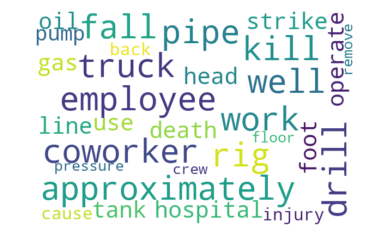

In [32]:
# Word Cloud of Top 30 Most Frequent Terms
from wordcloud import WordCloud
wordcloud = WordCloud(width=600, height=400, min_font_size=10, max_font_size=60, background_color='white').generate(mft)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.close()

**Now, we will move forward to generate a Term-Frequency sparse matrix using the `scikit-learn` library.**

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
cnvrt_to_str = new_word_tokens.apply(lambda t: ' '.join(t))
tfidf = TfidfVectorizer(use_idf=False, analyzer = 'word')
tf_matrix = tfidf.fit_transform(cnvrt_to_str)
tf_matrix

<1141x920 sparse matrix of type '<class 'numpy.float64'>'
	with 30805 stored elements in Compressed Sparse Row format>

Now that we created a TF matrix which contains 415 reports and 317 word tokens, it is hard to view it in a table. So, let's plot a heatmap of word tokens vs. documents using the `seaborn` library.

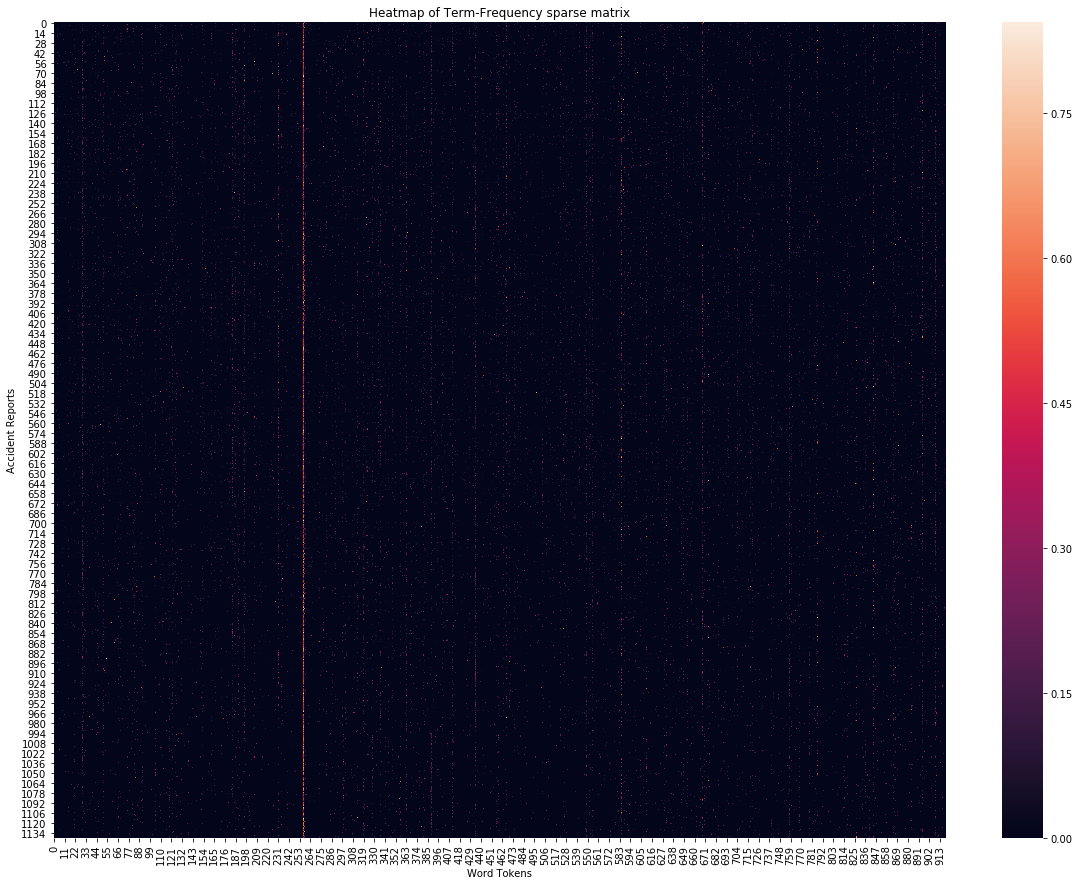

In [34]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(tf_matrix.todense(), ax=ax)
plt.title("Heatmap of Term-Frequency sparse matrix")
plt.xlabel("Word Tokens")
plt.ylabel("Accident Reports")
plt.show()
plt.close()

It is easy to notice how sparse the matrix is with one bright streak for the word 'employee'. And there are some patterns where usage of some words change over time with reports. Note that all the reports are sorted from 2017 to 2013. But we cannot discard the sparse terms without finding out if they add to any associations between documents. Because some words can be used frequently in few reports to explain specific type of accidents but not used in other reports. To attain that knowledge we need to generate a TF-IDF matrix. 

### Term Frequency - Inverse Document Frequency
In information retrieval, TFIDF short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Tf–idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf–idf.

In [35]:
# Generate a tf-idf matrix
tfidf = TfidfVectorizer(use_idf=True, analyzer = 'word')
tfidf_matrix = tfidf.fit_transform(cnvrt_to_str)
tfidf_matrix

<1141x920 sparse matrix of type '<class 'numpy.float64'>'
	with 30805 stored elements in Compressed Sparse Row format>

Similar to the term frequency matrix lets also plot a heatmap to find the differences between TF and TF-IDF matrices.

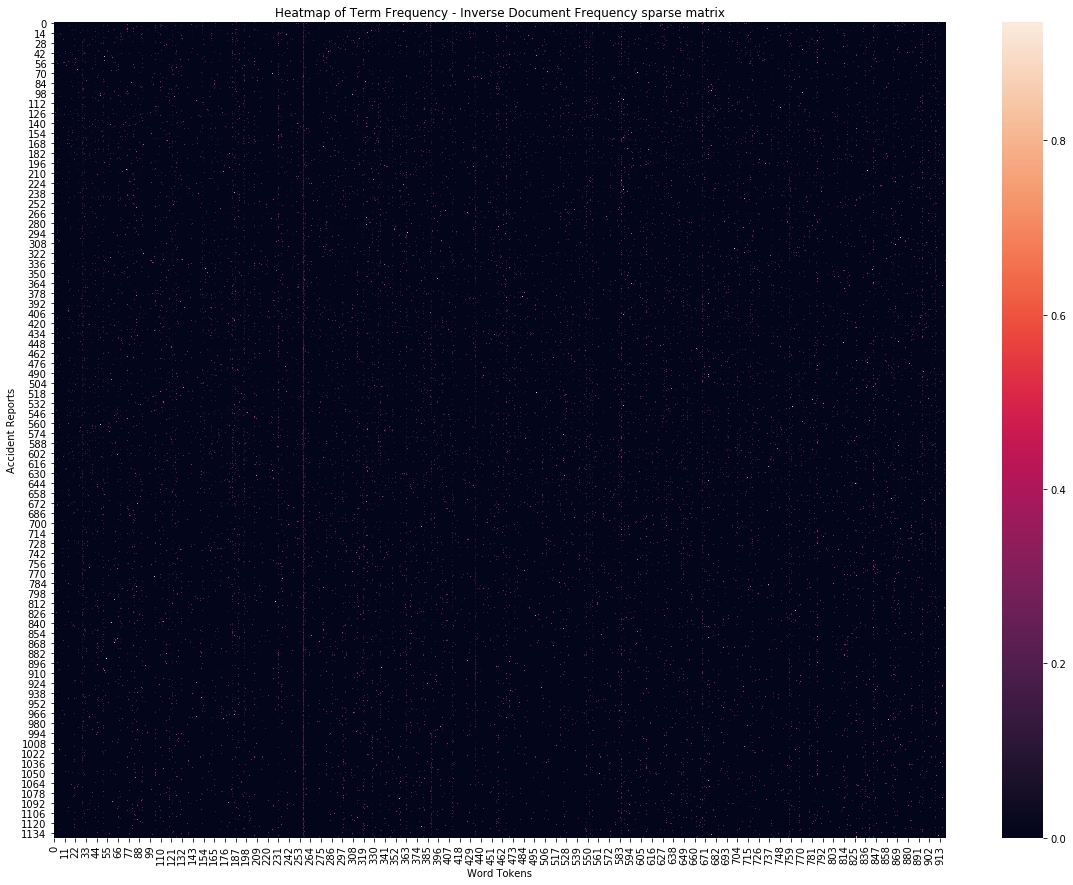

In [36]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(tfidf_matrix.todense(), ax=ax)
plt.title("Heatmap of Term Frequency - Inverse Document Frequency sparse matrix")
plt.xlabel("Word Tokens")
plt.ylabel("Accident Reports")
plt.show()
plt.close()

A quick difference to note is weightage for the word 'employee' is penalized as it occurs commonly between all documents. Similarly few other common words are penalized and several words weightage is increased. Overall there are subtle improvements in the sparsity of TF-IDF matrix. The next step is identify the top weighted words in the tf-idf matrix and compare them to the most frequent words to observe any differences. 

In [37]:
# Create pandas DataFrame from scipy csr matrix format
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names())

In [38]:
tfidf_df.head()
# rows are accident reports
# columns are word tokens

abdomen  able  abrasion  access  accident  accord  across  activate  \
0      0.0   0.0       0.0     0.0       0.0     0.0     0.0       0.0   
1      0.0   0.0       0.0     0.0       0.0     0.0     0.0       0.0   
2      0.0   0.0       0.0     0.0       0.0     0.0     0.0       0.0   
3      0.0   0.0       0.0     0.0       0.0     0.0     0.0       0.0   
4      0.0   0.0       0.0     0.0       0.0     0.0     0.0       0.0   

   activated  activity  ...   worker  working  workover  would  wound  wrap  \
0        0.0       0.0  ...      0.0      0.0  0.000000    0.0    0.0   0.0   
1        0.0       0.0  ...      0.0      0.0  0.000000    0.0    0.0   0.0   
2        0.0       0.0  ...      0.0      0.0  0.249069    0.0    0.0   0.0   
3        0.0       0.0  ...      0.0      0.0  0.000000    0.0    0.0   0.0   
4        0.0       0.0  ...      0.0      0.0  0.000000    0.0    0.0   0.0   

   wrench  yard  yearold  zone  
0     0.0   0.0      0.0   0.0  
1     0.0   0.0      0.0   0.0  
2     0.0   0.0      0.0   0.0  
3     0.0   0.0      0.0   0.0  
4     0.0   0.0      0.0   0.0  

[5 rows x 920 columns]

In [39]:
col_agg = tfidf_df.agg("sum")
top_idf = col_agg.sort_values(ascending = False)[:30]
print(top_idf)

employee         153.705403
pipe              62.842053
rig               49.879161
drill             48.632237
well              46.157958
kill              43.582302
truck             42.507485
approximately     40.763930
tank              39.118915
fall              38.604772
work              37.513852
strike            36.641535
coworker          34.098625
hospital          34.024073
head              33.656331
line              32.583790
oil               31.760956
death             30.792079
gas               29.285110
operate           27.551863
pressure          26.924113
pump              26.657729
injury            26.220409
foot              25.743647
floor             24.200079
burn              22.989572
use               22.648785
derrick           22.285822
cause             22.258076
water             22.054026
dtype: float64


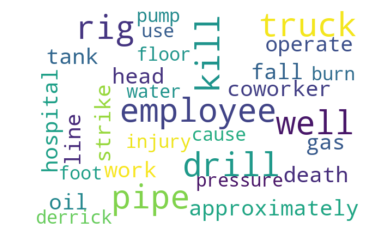

In [40]:
# Word Cloud of Top 30 TF-IDF terms
from wordcloud import WordCloud
top_idf = ' '.join(top_idf.index)
wordcloud = WordCloud(width=600, height=400, min_font_size=10, max_font_size=60, background_color='white').generate(top_idf)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.close()

In [41]:
# Compare top 30 terms between TF and TF-IDF matrices
pd.DataFrame({'TF' : mft.split(' '),
            'TF-IDF' : top_idf.split(' ')}) 

TF         TF-IDF
0        employee       employee
1            pipe           pipe
2             rig            rig
3            well          drill
4   approximately           well
5           drill           kill
6            work          truck
7        coworker  approximately
8           truck           tank
9            fall           fall
10           kill           work
11       hospital         strike
12            oil       coworker
13           line       hospital
14           tank           head
15         strike           line
16        operate            oil
17           head          death
18          death            gas
19            gas        operate
20           foot       pressure
21            use           pump
22           pump         injury
23         injury           foot
24           back          floor
25          cause           burn
26       pressure            use
27         remove        derrick
28          floor          cause
29           crew          water

Although mostly similar, several terms are promoted to a higher rank in TF-IDF when compared to TF. And miscellaneous words like 'approximately' and 'back' that are listed in TF do not exist in TF-IDF. Words like 'death', 'sustain' and 'injury'  moved several ranks in TF-IDF. New word 'crush' is in the TF-IDF list but not in TF. 

### Bag of Words:
Bag of Words (BoW) refers to the representation of text which describes the presence of words within the text data. The intuition behind this is that two similar text fields will contain similar kind of words, and will therefore have a similar bag of words.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(cnvrt_to_str)
bow_df = pd.DataFrame(train_bow.toarray(), columns = bow.get_feature_names())
bow_df.head()

abdomen  able  abrasion  access  accident  accord  across  activate  \
0        0     0         0       0         0       0       0         0   
1        0     0         0       0         0       0       0         0   
2        0     0         0       0         0       0       0         0   
3        0     0         0       0         0       0       0         0   
4        0     0         0       0         0       0       0         0   

   activated  activity  ...   worker  working  workover  would  wound  wrap  \
0          0         0  ...        0        0         0      0      0     0   
1          0         0  ...        0        0         0      0      0     0   
2          0         0  ...        0        0         1      0      0     0   
3          0         0  ...        0        0         0      0      0     0   
4          0         0  ...        0        0         0      0      0     0   

   wrench  yard  yearold  zone  
0       0     0        0     0  
1       0     0        0     0  
2       0     0        0     0  
3       0     0        0     0  
4       0     0        0     0  

[5 rows x 920 columns]

Bag of words is a preliminary technique yet the understanding it is essential for Continuou Bag of Words(CBOW), which is a more advanced and extended concept of Bag of Words. The methods discussed below are prediction based, in the sense that they provided probabilities to the words and proved to be state of the art for tasks like word analogies and word similarities. Another algorithm similar to CBOW in topology is Skip-Gram model, these two models together form an algorithm known as Word2Vec. Both of these models are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations. 

Word2Vec transcends from structurizing tokens in the form of word embeddings to buidling neural networks that can be modeled to predict multiple context based situations.  

## 4. Text Mining

This section deals with mining text data by using techniques to identify patterns and trends in text data with respect to other feature variables including target variable. Text mining acts as a preparatory stage to modeling text for classification. It is exploratory in nature and hence different techniques are used for identification of intelligent information among the variables in the dataset. Initially we will begin to explore each of the variables to know its range, distribution, number of levels and if necessary transform it to be able to apply and fit to the model well.

### Event Date

In [43]:
raw_data.Event_Date.describe()

count                    1141
unique                   1004
top       2005-12-19 00:00:00
freq                        3
first     2001-04-13 00:00:00
last      2017-12-31 00:00:00
Name: Event_Date, dtype: object

In [44]:
# One time use - Initiate plotly
import plotly
plotly.tools.set_credentials_file(username='binti', api_key='dv1XHP8ygm00itAg9m4C')

In [45]:
import plotly.offline as off
import plotly.graph_objs as go

off.init_notebook_mode(connected=False)

data = [dict(
  x = raw_data['Event_Date'],
  autobinx = False,
  autobiny = True,
  #marker = dict(color = 'rgb(68, 68, 68)'),
  name = 'date',
  type = 'histogram',
  xbins = dict(
    end = '2017-12-31',
    size = 'M1',
    start = '2001-01-01'
  )
)]

layout = dict(
  #paper_bgcolor = 'rgb(240, 240, 240)',
  #plot_bgcolor = 'rgb(240, 240, 240)',
  title = '<b>Oil & Gas Industry Accidents</b>',
  xaxis = dict(
    title = 'Years',
    tickangle=-90,
    type = 'date',
    nticks = 25
  ),
  yaxis = dict(
    title = 'Accident Count',
    type = 'linear'
  ),
  updatemenus = [dict(
        x = 0.1,
        y = 1.15,
        xref = 'paper',
        yref = 'paper',
        yanchor = 'top',
        active = 1,
        showactive = True,
        buttons = [
        dict(
            args = ['xbins.size', 'D1'],
            label = 'Day',
            method = 'restyle',
        ), dict(
            args = ['xbins.size', 'M1'],
            label = 'Month',
            method = 'restyle',
        ), dict(
            args = ['xbins.size', 'M3'],
            label = 'Quater',
            method = 'restyle',
        ), dict(
            args = ['xbins.size', 'M6'],
            label = 'Half Year',
            method = 'restyle',
        ), dict(
            args = ['xbins.size', 'M12'],
            label = 'Year',
            method = 'restyle',
        )]
  )]
)

off.iplot({'data': data,'layout': layout}, validate=False)

As the Event_Date field is niether numerical nor categorical we cannot use it directly for our analysis. And date itself is a very granular field which makes it further difficult for analysis. Hence new columns must be derived from date that are of relevance to the data. 

In [46]:
def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$','',fldname)
    for n in ('Year','Month','Week','Day','Dayofweek','Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt, n.lower())
        df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
        
add_datepart(raw_data, 'Event_Date')

**Day of Week vs Degree**

In [47]:
dydg_df = pd.DataFrame(raw_data.Event_Date.dt.day_name())
dydg_df['Degree'] = raw_data.Degree
dydg_df = pd.DataFrame(dydg_df.groupby(['Event_Date','Degree']).size().reset_index(name='count'))
dydg_df = dydg_df.pivot(index='Event_Date', columns='Degree', values='count')
dydg_df.reset_index(inplace=True)
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=cats, ordered=True)
dydg_df.Event_Date = dydg_df.Event_Date.astype(cat_type)
dydg_df.sort_values('Event_Date', inplace=True)

In [48]:
trace1 = go.Bar(
    x=dydg_df.Event_Date,
    y=dydg_df.Fatality,
    name='Fatality'
)
trace2 = go.Bar(
    x=dydg_df.Event_Date,
    y=dydg_df['Hospitalized injury'],
    name='Hospitalized Injury'
)
trace3 = go.Bar(
    x=dydg_df.Event_Date,
    y=dydg_df['Non Hospitalized injury'],
    name='Non Hospitalized Injury'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = '<b>Day of Week vs Degree</b>',
    yaxis = dict(
    title = 'Accident Count (2013-2017)',
    type = 'linear'
    ),
    xaxis = dict(
    title = 'Days of Week'), 
    legend=dict(x=0, y=1.1, orientation='h')
)

fig = go.Figure(data=data, layout=layout)
off.iplot(fig, validate=False)


**Month vs Degree**

In [49]:
mdg = pd.DataFrame(raw_data.Event_Date.dt.month_name())
mdg['Degree'] = raw_data.Degree
mdg = pd.DataFrame(mdg.groupby(['Event_Date','Degree']).size().reset_index(name='count'))
mdg = mdg.pivot(index='Event_Date', columns='Degree', values='count')
mdg.reset_index(inplace=True)
cats = ['January', 'February', 'March', 'April','May','June', 'July', 'August','September', 'October', 'November', 'December']
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=cats, ordered=True)
mdg.Event_Date = mdg.Event_Date.astype(cat_type)
mdg.sort_values('Event_Date', inplace=True)

In [50]:
trace1 = go.Bar(
    x=mdg.Event_Date,
    y=mdg.Fatality,
    name='Fatality'
)
trace2 = go.Bar(
    x=mdg.Event_Date,
    y=mdg['Hospitalized injury'],
    name='Hospitalized Injury'
)
trace3 = go.Bar(
    x=mdg.Event_Date,
    y=mdg['Non Hospitalized injury'],
    name='Non Hospitalized Injury'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = '<b>Month vs Degree</b>',
    xaxis=dict(
    tickangle=-45,
    title = 'Months'),
    yaxis = dict(
    title = 'Accident Count (2013-2017)',
    type = 'linear'
    ),
    legend=dict(x=0, y=1.1, orientation='h')
)

fig = go.Figure(data=data, layout=layout)
off.iplot(fig, validate=False)


### Time field
Time field is modified to contain only hourly info which accounts to 24 hours per day. That still might be needed to reduced to 4 levels for better performance of the model

**Time vs Degree:** 

In [51]:
hdg = pd.DataFrame({'Time':raw_data.Time, 'Degree':raw_data.Degree})
hdg = pd.DataFrame(hdg.groupby(['Time','Degree']).size().reset_index(name='count'))
hdg = hdg.pivot(index='Time', columns='Degree', values='count')
hdg.reset_index(inplace=True)

In [52]:
trace1 = go.Bar(
    x=hdg.Time,
    y=hdg.Fatality,
    name='Fatality'
)
trace2 = go.Bar(
    x=hdg.Time,
    y=hdg['Hospitalized injury'],
    name='Hospitalized Injury'
)
trace3 = go.Bar(
    x=hdg.Time,
    y=hdg['Non Hospitalized injury'],
    name='Non Hospitalized Injury'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = '<b>Hour of Day vs Degree</b>',
    xaxis = dict(
    title = 'Hours of Day (24 hour format)',
    nticks = 24
    ),
    yaxis = dict(
    title = 'Accident Count',
    type = 'linear'
    ),
    legend=dict(x=0, y=1.1, orientation='h')
)

fig = go.Figure(data=data, layout=layout)
off.iplot(fig, validate=False)


It is clearly obvious that most accidents occur during 8am to 5pm period. There is a broader distinction between degree levels in the first half of the day. Instead of having 24 levels it helps to reduce the levels to four for every 6 hours. We will create a new variable Hour_Range for 7am-12pm, 1pm-6pm, 7pm-12am, 1am-6pm

In [53]:
raw_data['Hour_Range'] = raw_data.Time.cat.codes
raw_data['Hour_Range'] = raw_data.Hour_Range.astype('int32', errors='ignore')

def cnvrt_hour(val):
    if val>=1 and val<=6:
        return "1am-6pm"
    elif val>=7 and val<=12:
        return "7am-12pm"
    elif val>=13 and val<=18:
        return "1pm-6pm"
    elif val==0 or (val>= 19 and val<=23):
        return "7pm-12am"
    else:
        return None
        
raw_data.Hour_Range = raw_data.Hour_Range.apply(lambda i: cnvrt_hour(i))
cats = ["1am-6pm", "7am-12pm", "1pm-6pm", "7pm-12am"]
cat_type = CategoricalDtype(categories=cats, ordered=True)
raw_data.Hour_Range = raw_data.Hour_Range.astype(cat_type)

In [54]:
hrdg = pd.DataFrame({'Hour_Range':raw_data.Hour_Range, 'Degree':raw_data.Degree})
hrdg = pd.DataFrame(hrdg.groupby(['Hour_Range','Degree']).size().reset_index(name='count'))
hrdg = hrdg.pivot(index='Hour_Range', columns='Degree', values='count')
hrdg.reset_index(inplace=True)
cats = ["1am-6pm", "7am-12pm", "1pm-6pm", "7pm-12am"]
cat_type = CategoricalDtype(categories=cats, ordered=True)
hrdg.Hour_Range =hrdg.Hour_Range.astype(cat_type)
hrdg.sort_values('Hour_Range', inplace=True)

In [55]:
trace1 = go.Bar(
    x=hrdg.Hour_Range,
    y=hrdg.Fatality,
    name='Fatality'
)
trace2 = go.Bar(
    x=hrdg.Hour_Range,
    y=hrdg['Hospitalized injury'],
    name='Hospitalized Injury'
)
trace3 = go.Bar(
    x=hrdg.Hour_Range,
    y=hrdg['Non Hospitalized injury'],
    name='Non Hospitalized Injury'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = '<b>Hour of Day vs Degree</b>',
    yaxis = dict(
    title = 'Accident Count',
    type = 'linear'
    ),
    legend=dict(x=0, y=1.1, orientation='h')
)

fig = go.Figure(data=data, layout=layout)
off.iplot(fig, validate=False)

### Age and Nature fields

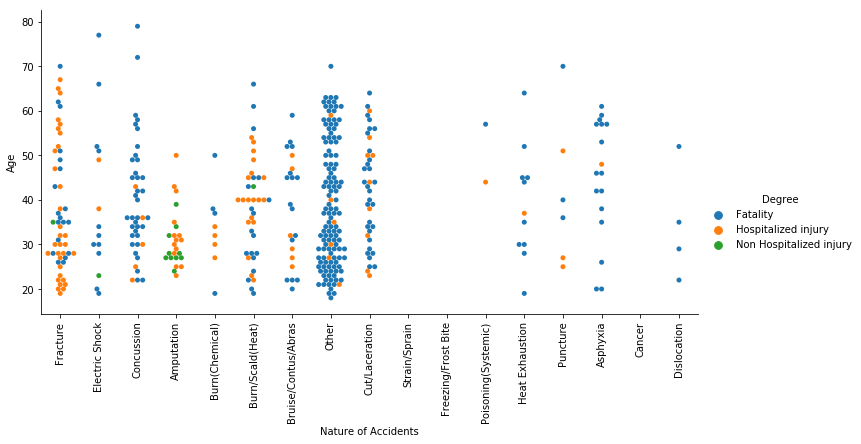

In [56]:
import seaborn as sns
g = sns.catplot(x='Nature', y='Age', hue='Degree', kind='swarm', data=raw_data, height=5, aspect=2)
g.set_axis_labels("Nature of Accidents","Age") 
g.set_xticklabels(rotation=90)

### Establishment Field

In [57]:
raw_data.Establishment = raw_data.Establishment.astype('category')
estdf = pd.DataFrame(raw_data.Establishment)
estdf['Degree'] = raw_data.Degree
estdf = pd.DataFrame(estdf.groupby(['Establishment','Degree']).size().reset_index(name='count'))
estdf = estdf.pivot(index='Establishment', columns='Degree', values='count')
estdf.reset_index(inplace=True)

In [58]:
trace1 = go.Bar(
    x=estdf.Establishment,
    y=estdf.Fatality,
    name='Fatality'
)
trace2 = go.Bar(
    x=estdf.Establishment,
    y=estdf['Hospitalized injury'],
    name='Hospitalized Injury'
)
trace3 = go.Bar(
    x=estdf.Establishment,
    y=estdf['Non Hospitalized injury'],
    name='Non Hospitalized Injury'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title = '<b>Establishment vs Degree</b>',
    yaxis = dict(
    title = 'Accident Count',
    type = 'linear'
    ),
    legend=dict(x=0, y=1.1, orientation='h')
)

fig = go.Figure(data=data, layout=layout)
off.iplot(fig, validate=False)

### Word2Vec

In [71]:
from gensim.models import word2vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

text_corpus = new_word_tokens.tolist()
model = word2vec.Word2Vec(text_corpus, size=300, window=20, min_count=200, workers=4)

In [93]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(8,6))
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
#     plt.xlim(x_coords.min(), x_coords.max())
#     plt.ylim(y_coords.min(), y_coords.max())
        plt.title('Words most similar to '+word)    
    plt.show()

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


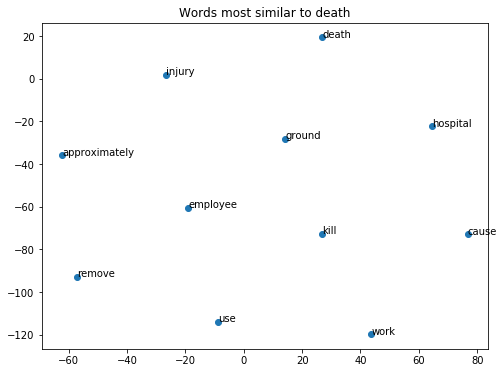

In [94]:
display_closestwords_tsnescatterplot(model, 'death')

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


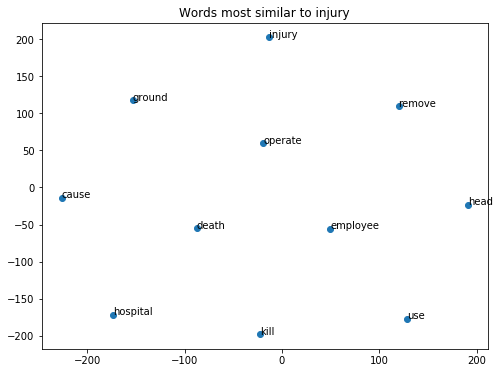

In [95]:
display_closestwords_tsnescatterplot(model, 'injury')

In [95]:
import scattertext as st
import spacy
from pprint import pprint

nlp = spacy.load('en')
text = new_word_tokens.str.join(' ')
viz_df = pd.DataFrame({'Degree' : raw_data.Degree,
                        'Nature': raw_data.Nature,
                        'text' : text})

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\msgpack_numpy.py:214: PendingDeprecationWarning:

encoding is deprecated, Use raw=False instead.



In [96]:
corpus = st.CorpusFromPandas(viz_df, 
                              category_col='Degree', 
                              text_col='text',
                              nlp=nlp).build()

html = st.produce_scattertext_explorer(corpus,
          category='Fatality',
          category_name='Fatality',
          not_category_name='Injury',
          width_in_pixels=1000,
          metadata=viz_df['Nature'])
open("Word2Vec-Visualization.html", 'wb').write(html.encode('utf-8'))

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\numpy\matrixlib\defmatrix.py:68: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\scattertext\TermDocMatrix.py:890: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\ipykernel\__main__.py:12: ResourceWarning:

unclosed file <_io.BufferedWriter name='Word2Vec-Visualization.html'>



909333

## 5. Advanced Analytics

### Preliminary Model Building


**Data Setup**

In [59]:
# Combine all predictor variables and prep data
dfmod = pd.concat([raw_data.iloc[:,[4,5]],raw_data.iloc[:,8:-1]], axis=1)
dfmod.reset_index(drop = True, inplace = True)
dfmod = pd.concat([dfmod, tfidf_df], axis=1)
dfmod.Nature = dfmod.Nature.astype('category').cat.as_ordered()
dfmod.Nature = dfmod.Nature.cat.codes+1
dfmod.Establishment = dfmod.Establishment.astype('category').cat.as_ordered()
dfmod.Establishment = dfmod.Establishment.cat.codes+1
y = raw_data.Degree
dfmod.tail()

Nature  Establishment  Event_Year  Event_Elapsed  Event_Month  \
1136       7            810        2017           6073           11   
1137      11             40        2017           6079           12   
1138      11            730        2017           6096           12   
1139      11            365        2017           6105           12   
1140      14             19        2017           6106           12   

      Event_Week  Event_Day  Event_Dayofweek  Event_Is_month_end  \
1136          48         28                1               False   
1137          49          4                0               False   
1138          51         21                3               False   
1139          52         30                5               False   
1140          52         31                6                True   

      Event_Is_month_start  ...   worker  working  workover  would  wound  \
1136                 False  ...      0.0      0.0  0.000000    0.0    0.0   
1137                 False  ...      0.0      0.0  0.000000    0.0    0.0   
1138                 False  ...      0.0      0.0  0.647686    0.0    0.0   
1139                 False  ...      0.0      0.0  0.000000    0.0    0.0   
1140                 False  ...      0.0      0.0  0.000000    0.0    0.0   

      wrap  wrench  yard  yearold  zone  
1136   0.0     0.0   0.0      0.0   0.0  
1137   0.0     0.0   0.0      0.0   0.0  
1138   0.0     0.0   0.0      0.0   0.0  
1139   0.0     0.0   0.0      0.0   0.0  
1140   0.0     0.0   0.0      0.0   0.0  

[5 rows x 934 columns]

**Model Selection**

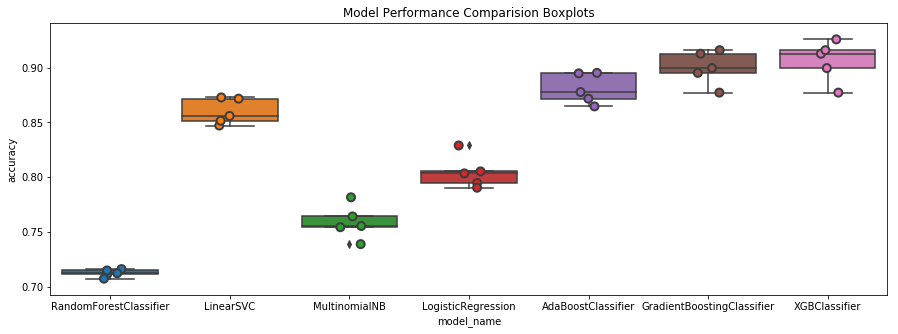

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import warnings; warnings.simplefilter('ignore')
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    AdaBoostClassifier(random_state=1),
    GradientBoostingClassifier(learning_rate=0.01,random_state=1),
    xgb.XGBClassifier(random_state=1,learning_rate=0.01)
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
features = dfmod.iloc[:,14:]
labels = raw_data.Degree.astype('category').cat.as_ordered()

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
f, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Model Performance Comparision Boxplots')
plt.show()
plt.close()

In [61]:
print("Mean Accuracies")
print(cv_df.groupby('model_name').accuracy.mean())
print('\nMedian Accuracies')
print(cv_df.groupby('model_name').accuracy.median())

Mean Accuracies
model_name
AdaBoostClassifier            0.880795
GradientBoostingClassifier    0.900109
LinearSVC                     0.859815
LogisticRegression            0.804581
MultinomialNB                 0.758927
RandomForestClassifier        0.712535
XGBClassifier                 0.906223
Name: accuracy, dtype: float64

Median Accuracies
model_name
AdaBoostClassifier            0.877729
GradientBoostingClassifier    0.899563
LinearSVC                     0.855895
LogisticRegression            0.803493
MultinomialNB                 0.755459
RandomForestClassifier        0.712389
XGBClassifier                 0.912664
Name: accuracy, dtype: float64


**Model Evaluation**<br>
Lets continue with our best models, we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

**Linear SVC**

Accuracy: 0.8636363636363636
                         precision    recall  f1-score   support

               Fatality       0.89      0.97      0.93       202
    Hospitalized injury       0.76      0.74      0.75        68
Non Hospitalized injury       1.00      0.06      0.12        16

              micro avg       0.86      0.86      0.86       286
              macro avg       0.88      0.59      0.60       286
           weighted avg       0.87      0.86      0.84       286



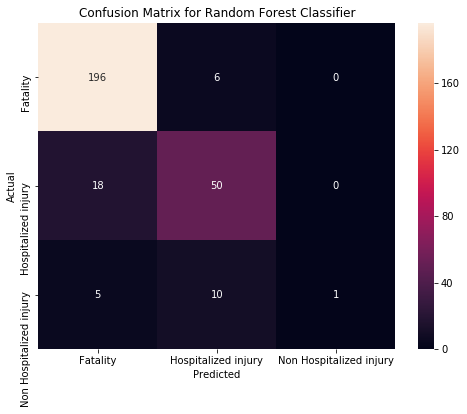

In [62]:
model = LinearSVC()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(tfidf_df, labels, df.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy:',model.score(X_test,y_test))
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=y.unique()))

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.cat.categories, yticklabels=labels.cat.categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()
plt.close()

**XGBoost**

In [63]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

model = xgb.XGBClassifier(
 learning_rate =0.2,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 scaled_pos_weight=1,
 colsample_bytree=0.8,
 seed=27, 
 n_jobs=4, 
 objective= 'multi:softmax', 
 num_class = 3)
xgb1 = model
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(tfidf_df, labels, df.index, test_size=0.25, random_state=0)

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

print('Accuracy:', model.score(X_test,y_test))

Accuracy: 0.9125874125874126


**Step 1: Fix learning rate and number of estimators for tuning tree-based parameters**
The above is an XGBoost model tuned with basic common parameters, tested with a 25% test set. In the next iteration we will test out with Cross Validation to estimate optimal learning rate and estimators

In [64]:
# Wrapper function to run XGBoost with cross validation and to determine optimum learning rate, estimators

def modelfit(alg, dXtrain, dytrain, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    from sklearn.metrics import classification_report
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dXtrain.values, label=dytrain.cat.codes)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             metrics = 'merror', early_stopping_rounds=early_stopping_rounds, stratified=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dXtrain, dytrain, eval_metric='merror')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dXtrain)
    dtrain_predprob = alg.predict_proba(dXtrain)[:,1]
        
    #Print model report:
    print("\nModel Classification Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dytrain.values, dtrain_predictions))
    report = classification_report(dytrain.values, dtrain_predictions)
    print(report)
    print(cvresult)

In [65]:
modelfit(xgb1, X_train, y_train)


Model Classification Report
Accuracy : 1
                         precision    recall  f1-score   support

               Fatality       1.00      1.00      1.00       607
    Hospitalized injury       1.00      1.00      1.00       215
Non Hospitalized injury       1.00      1.00      1.00        33

              micro avg       1.00      1.00      1.00       855
              macro avg       1.00      1.00      1.00       855
           weighted avg       1.00      1.00      1.00       855

    train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0            0.069305          0.008947          0.104089         0.014461
1            0.061704          0.009720          0.097085         0.009535
2            0.058778          0.008482          0.102954         0.011070
3            0.054686          0.010023          0.099390         0.009493
4            0.052347          0.006941          0.095902         0.006929
5            0.050006          0.006340          0

**Step 2: Tune max_depth and min_child_weight**

In [66]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from xgboost.sklearn import XGBClassifier
import warnings; warnings.simplefilter('once')

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.2, n_estimators=39, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', num_class=3, n_jobs=4, scale_pos_weight=1, random_state=27), 
 param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5, return_train_score=True)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([1.44618001, 1.46797004, 1.41225696, 2.27884207, 2.20158243,
         2.11104193, 2.66709175, 2.61301799, 2.67399192, 3.28455067,
         2.52238307, 2.31719351]),
  'std_fit_time': array([0.02529008, 0.01386675, 0.02765835, 0.04503368, 0.04453664,
         0.16120444, 0.16754469, 0.38550103, 0.03955055, 0.20137817,
         0.11080851, 0.27582671]),
  'mean_score_time': array([0.02024093, 0.0209147 , 0.02047005, 0.02052207, 0.02326288,
         0.02743382, 0.03083887, 0.03592062, 0.02731681, 0.0190001 ,
         0.02277751, 0.0197515 ]),
  'std_score_time': array([0.00317729, 0.00222571, 0.00474218, 0.00327961, 0.00557131,
         0.00598266, 0.01383149, 0.01470163, 0.01448563, 0.00387106,
         0.00319838, 0.00991975]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

**Step 3: Tune Gamma**

In [67]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.2, n_estimators=39, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', num_class=3, n_jobs=4, scale_pos_weight=1, random_state=27), 
 param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=5, return_train_score=True)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([1.44058695, 1.35863476, 1.17899237, 1.18014741, 1.24956141]),
  'std_fit_time': array([0.01272259, 0.10271038, 0.04281307, 0.06139474, 0.20749264]),
  'mean_score_time': array([0.02243042, 0.01666408, 0.015556  , 0.02657518, 0.02182226]),
  'std_score_time': array([0.00759371, 0.00213484, 0.00159788, 0.00522937, 0.00989288]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.94186047, 0.93604651, 0.94186047, 0.93023256, 0.94186047]),
  'split1_test_score': array([0.9244186 , 0.9244186 , 0.93023256, 0.9244186 , 0.93023256]),
  'split2_test_score': array([0.92397661, 0.92982456, 0.92982456, 0.92397661, 0.92982456]),
  'split3_test_score': array([0.92941176, 0.92352941, 0.92941176, 0.92941176, 0.92941176]),

In [68]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# create timer func
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 2, 3, 4],
        'gamma': [0, 0.2, 0.4, 0.6, 0.8],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3, 4, 5],
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
        
        }

clf = XGBClassifier(learning_rate=0.2, n_estimators=300, objective='multi:softmax', num_class=3,
                    silent=True, n_jobs=4, random_state=27, scaled_pos_weight=1)

folds = 5
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='f1_micro', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   53.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.5min finished



 Time taken: 0 hours 1 minutes and 35.6 seconds.


In [69]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([ 4.04929843,  9.77025647,  8.99406633, 12.53936763,  5.97206244,
        3.66741266,  3.77480464, 13.03108497,  3.91463828,  4.0526772 ]), 'std_fit_time': array([0.53228771, 0.32292288, 0.15370917, 0.33784085, 0.42616948,
       0.03407288, 0.08096755, 0.53050936, 0.10505119, 0.37348618]), 'mean_score_time': array([0.02491627, 0.04086246, 0.03344445, 0.03419261, 0.03608432,
       0.03411932, 0.03110251, 0.03339109, 0.04125872, 0.01929178]), 'std_score_time': array([0.00644311, 0.01211174, 0.01285761, 0.01093972, 0.00806096,
       0.00450045, 0.00734739, 0.01282761, 0.01284693, 0.00812353]), 'param_subsample': masked_array(data=[0.8, 0.8, 1.0, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_reg_alpha': masked_array(data=[100, 1e-05, 1e-05, 1e-05, 0.01, 0.01, 100, 0.1, 1, 100],
             mask

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

C:\Users\Astron\Anaconda3\envs\tm_oil\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training scor

In [70]:
xgb2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=39,
       n_jobs=4, nthread=None, num_class=3, objective='multi:softmax',
       random_state=27, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       scaled_pos_weight=1, seed=None, silent=True, subsample=1.0)

model = xgb2.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

from sklearn.metrics import classification_report
print('Accuracy:', metrics.accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.9265734265734266
                         precision    recall  f1-score   support

               Fatality       0.96      1.00      0.98       202
    Hospitalized injury       0.84      0.91      0.87        68
Non Hospitalized injury       1.00      0.12      0.22        16

              micro avg       0.93      0.93      0.93       286
              macro avg       0.93      0.68      0.69       286
           weighted avg       0.93      0.93      0.91       286

